## Варіант 5
 ### Завдання  1. Побудувати кубічний сплайн для таблично заданої функції, з граничними умовами для першої похідної.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display, Markdown, Math
from matplotlib.pyplot import figure
from numpy.polynomial import polynomial
from scipy.sparse import diags
from scipy.interpolate import interp1d, CubicSpline

def init_fig():
    global figure
    figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;margin:0px auto;}
.tg td{border-style:solid;border-width:0px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;
  padding:10px 5px;word-break:normal;}
.tg th{border-style:solid;border-width:0px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
<tbody>
  <tr>
    <td class="tg-c3ow">$i$</td>
    <td class="tg-c3ow">0</td>
    <td class="tg-c3ow">1</td>
    <td class="tg-c3ow">2</td>
    <td class="tg-c3ow">3</td>
    <td class="tg-0pky">$S'$</td>
  </tr>
  <tr>
    <td class="tg-c3ow">$X$</td>
    <td class="tg-c3ow">-4</td>
    <td class="tg-c3ow">1</td>
    <td class="tg-c3ow">3</td>
    <td class="tg-c3ow">7</td>
    <td class="tg-0pky">$S'(a)=-1$</td>
  </tr>
  <tr>
    <td class="tg-0lax">$Y$</td>
    <td class="tg-0lax">2</td>
    <td class="tg-0lax">5</td>
    <td class="tg-0lax">-3</td>
    <td class="tg-0lax">0</td>
    <td class="tg-0lax">$S'(b)=2$</td>
  </tr>
</tbody>
</table>

Побудова сплайну буде проводитись за першим способом з файлу, що був надісланий ("КУБІЧНА СПЛАЙН -НТЕРПОЛЯЦІЯ.pdf")

Сплайн матиме вигляд $S(x)=a_{i}+b_{i}(x-x_{i-1})+c_{i}(x-x_{i-1})^{2}+d_{i}(x-x_{i-1})^{3}$

В завданні задані граничні перші похідні, отже будуть використовуватися крайові умови першого типу в точках $x_0$ та $x_N$.

$$S^{\prime}\left(x_{0}\right)=f^{\prime}\left(x_{0}\right) ; \quad S^{\prime}\left(x_{N}\right)=f^{\prime}\left(x_{N}\right)$$

$$\left\{\begin{array}{l}b_{1}=f^{\prime}\left(x_{0}\right) \\ b_{N}+2 c_{N} h_{N}+3 d_{N} h_{n}^{2}=f^{\prime}\left(x_{N}\right)\end{array}\right.$$

Для знаходження коефіцієнтів $c_i$ треба знайти розв'язок наступної СЛАР

$$
\left\{\begin{array}{l}
2 c_{1}+c_{2}=3 \dfrac{y_{1}-y_{0}}{h_{1}^{2}}-\dfrac{3}{h_{1}} f^{\prime} x_{0} \\
h_{i-1} c_{i-1}+2 c_{i}\left(h_{i}+h_{i-1}\right)+h_{i} c_{i+1}=3\left[\dfrac{y_{i}-y_{i-1}}{h_{i}}-\dfrac{y_{i-1}-y_{i-2}}{h_{i-1}}\right], \quad i=\overline{2, N-1} \\
\dfrac{2}{3} h_{N-1} c_{N-1}+\left(h_{N}+\dfrac{4}{3} h_{N-1}\right) c_{N}=-f^{\prime}\left(x_{N}\right)-2 \dfrac{y_{N-1}-y_{N-2}}{h_{N-1}}+3 \dfrac{y_{N}-y_{N-1}}{h_{N}}
\end{array}\right.
$$

За другою граничною умовою
$$
\left\{\begin{array}{l}
c_{1}=\frac{1}{2} f^{\prime \prime}\left(x_{0}\right) \\
h_{i-1} c_{i-1}+2 c_{i} h_{i}+h_{i-1}+h_{i} c_{i+1}=3\left[\frac{y_{i}-y_{i-1}}{h_{i}}-\frac{y_{i-1}-y_{i-2}}{h_{i-1}}\right], \quad i=\overline{2, N-1} \\
h_{N-1} c_{N-1}+2 c_{N} \quad h_{N}+h_{N-1}=-f^{\prime \prime}\left(x_{N}\right) \frac{h_{N}}{2}+3\left(\frac{y_{N}-y_{N-1}}{h_{N}}-\frac{y_{N-1}-y_{N-2}}{h_{N-1}}\right)
\end{array}\right.
$$

$h_i$ - різниці $x_i - x_{i-1}, i=\overline{1, N}$

In [36]:
X = np.array(
    [-4, 1, 3, 7]
)
Y = np.array(
    [2, 5, -3, 0]
)
Spr_a = -1
Spr_b = 2

H = X[1:] - X[:-1]

# Warning
# index N in formulas is [-1] in arrays 

#################################################      DISPLAY
display(Markdown("#### Таблиця вхідних точок"))
table = pd.concat([
        pd.DataFrame(X),
        pd.DataFrame(Y),
        pd.DataFrame(np.concatenate([[0], H])),
    ], axis=1)
table.columns = [
    '$x_i$',
    '$y_i$',
    '$h_i$',
    ]
display(table.T)
###############################################################

# diagonal-based input
# C_coef_unsolved = diags(
#     [
#         np.concatenate((H[:-2], np.array([2/3*H[-2]]) )),
#         np.concatenate((np.array([2]), (H[1:-1]+H[0:-2])*2, np.array([H[-1]+4/3*H[-2]]) )), 
#         np.concatenate((np.array([1]), H[1:-1]))
#     ],
#     [-1, 0, 1],
#     shape=[len(H)]*2
# ).toarray()

C_coef_unsolved = diags(
    [
        np.concatenate((H[:-2], np.array([H[-2]]) )),
        np.concatenate((np.array([1]), (H[1:-1]+H[0:-2])*2, np.array([2*(H[-1]+H[-2])]) )), 
        np.concatenate((np.array([0]), H[1:-1]))
    ],
    [-1, 0, 1],
    shape=[len(H)]*2
).toarray()

# equals b
# b = np.concatenate((
#     np.array([ 3*(Y[1]-Y[0])/H[0]**2 - 3/H[0]*Spr_a ]),
#     3*((Y[2:-1]-Y[1:-2])/H[1:-1] - (Y[1:-2]-Y[0:-3])/H[0:-2]),
#     np.array([ -Spr_b - 2*((Y[-2] - Y[-3])/H[-2]) + 3*( (Y[-1] - Y[-2])/H[-1] ) ])
# ))

b = np.concatenate((
    np.array([ 1/2*Spr_a ]),
    3*((Y[2:-1]-Y[1:-2])/H[1:-1] - (Y[1:-2]-Y[0:-3])/H[0:-2]),
    np.array([ -Spr_b*H[-1]/2 + 3*( (Y[-1] - Y[-2])/H[-1] - (Y[-2] - Y[-3])/H[-2]) ])
))

# solve the system of linear equations
C = np.linalg.solve(C_coef_unsolved, b)

#################################################      DISPLAY
display(Markdown("#### Трьохдіагональна матриця системи"))
display(pd.DataFrame(C_coef_unsolved))
display(Markdown("#### Вектор-стовпчик вільних членів"))
display(pd.DataFrame(b))
display(Markdown("#### Значення коефіцієнтів $c_i$"))
display(pd.DataFrame(C, columns=["$c_i$"], index=np.arange(1,C.size+1)))
###############################################################


#### Таблиця вхідних точок

,0,1,2,3
$x_i$,-4,1,3,7
$y_i$,2,5,-3,0
$h_i$,0,5,2,4


#### Трьохдіагональна матриця системи

,0,1,2
0,1.0,0.0,0.0
1,5.0,14.0,2.0
2,0.0,2.0,12.0


#### Вектор-стовпчик вільних членів

,0
0,-0.50
1,-13.80
2,10.25


#### Значення коефіцієнтів $c_i$

,$c_i$
1,-0.500000
2,-0.951829
3,1.012805


Знаходження решти коефіцієнтів буде відбуватись згідно системи нижче
$$
\left\{\begin{array}{l}
a_{i}=y_{i-1}, \quad i=\overline{1, N}\\
b_{i}=\dfrac{y_{i}-y_{i-1}}{h_{i}}-\dfrac{h_{i}}{3}\left(c_{i+1}+2 c_{i}\right), \quad i=\overline{1, N-1} \\
b_{N}=\dfrac{y_{N-1}-y_{N-2}}{h_{N-1}}+\dfrac{h_{N-1}}{3}\left(2 c_{N}+c_{N-1}\right) \\
d_{i}=\dfrac{c_{i+1}-c_{i}}{3 h_{i}}, \quad i=\overline{1, N-1} \\
d_{N}=\dfrac{f^{\prime}\left(x_{n}\right)-b_{N}-2 c_{N} h_{N}}{3 h_{N}^{2}} \\
\end{array}\right.
$$
За другою граничною умовою
$$
\left\{\begin{array}{l}
d_{N}=\frac{f^{\prime \prime}\left(x_{N}\right)-2 c_{N}}{6 h_{N}} ; \quad d_{i}=\frac{c_{i+1}-c_{i}}{3 h_{i}}, i=\overline{1, N-1} \\
b_{N}=\frac{y_{N}-y_{N-1}}{h_{N}}-\frac{h_{N}}{6} f^{\prime \prime}\left(x_{N}\right)-\frac{2}{3} c_{N} h_{N} \\
b_{i}=b_{i+1}-h_{i} c_{i}+c_{i+1}, i=\overline{N-1,1} \\
a_{i}=y_{i-1}, i=\overline{1, N}
\end{array}\right.
$$

0 -3.2841463414634147 -1.9036585365853655 -1.9036585365853655
0 -3.4060975609756103 -2.5 -2.5
[ 3.85304878 -3.40609756 -3.28414634]


$x \in \left[-4;1\right]$

$x \mapsto \text{2.0} + \text{3.853}\,(x + 4) - \text{0.5}\,(x + 4)^{2} - \text{0.03}\,(x + 4)^{3}$

$x \in \left[1;3\right]$

$x \mapsto \text{5.0} - \text{3.406}\,(x - 1) - \text{0.952}\,(x - 1)^{2} + \text{0.327}\,(x - 1)^{3}$

$x \in \left[3;7\right]$

$x \mapsto \text{-3.0} - \text{3.284}\,(x - 3) + \text{1.013}\,(x - 3)^{2} - \text{0.001}\,(x - 3)^{3}$

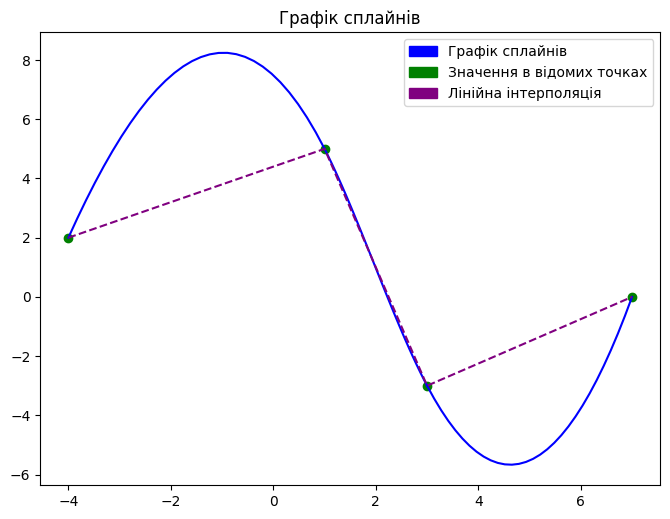

In [37]:
A = Y[:-1]
# B_i = (Y[1:-1] - Y[0:-2])/H[:-1] - H[:-1]/3*(C[1:] + 2*C[:-1])
# B_i = (Y[1:-1] - Y[0:-2])/H[:-1] - H[:-1]/3*(C[1:] + 2*C[:-1])
# B_N = np.array([(Y[-2] - Y[-3])/H[-2] + H[-2]/3*(2*C[-1] + C[-2])])
B_N = (Y[-1] - Y[-2])/H[-1] - H[-1]/6*Spr_b - 2/3*C[-1]*H[-1]
B_i = [0]*(len(X)-1)
B_i[-1] = B_N
for i in range(len(X)-3, -1, -1):
    print(B_i[i], B_i[i+1], H[i]*C[i], H[i]*C[i])
    
    B_i[i] = B_i[i+1] - H[i]*(C[i] + C[i+1])

B = np.array(B_i)
print(B)

# D_i = (C[1:] - C[:-1])/(3*H[:-1])
D_i = (C[1:] - C[:-1])/(3*H[:-1])
# D_N = np.array([( Spr_b - B[-1] - 2*C[-1]*H[-1] )/(3*H[-1]**2)])
D_N = np.array([ (Spr_b - 2*C[-1])/H[-1]/6 ])
D = np.concatenate(( D_i, D_N ))

S = np.concatenate((
        A[:, np.newaxis],
        B[:, np.newaxis],
        C[:, np.newaxis],
        D[:, np.newaxis],
    ),
    axis=1
)
polys = [polynomial.Polynomial(i) for i in S]

#################################################      DISPLAY
for i in range(len(X)-1):
    polys_disp = [polynomial.Polynomial(i) for i in np.round(S, 3)]
    display(Markdown(f"$x \in \\left[{X[i]};{X[i+1]}\\right]$"))
    display(Markdown(
        polys_disp[i]._repr_latex_(
        ).replace(',x', f',(x - {str(X[i])})' if X[i]>0 else f',(x + {str(X[i])[1:]})')
    ))

init_fig()
xmin, xmax = X.min(), X.max()
points = plt.plot(X, Y, 'go')
for i in range(len(X)-1):
    lin_space = np.linspace(X[i], X[i+1], 30)
    plt.plot(lin_space, polys[i](lin_space-X[i]), 'b')
lin_space = np.linspace(xmin, xmax, 100)
linear_f = interp1d(X, Y)
linear = plt.plot(lin_space, linear_f(lin_space), color='purple', linestyle='dashed',)
blue_patch = mpatches.Patch(color='blue', label='Графік сплайнів')
green_patch = mpatches.Patch(color='green', label='Значення в відомих точках')
purple_patch = mpatches.Patch(color='purple', label='Лінійна інтерполяція')
plt.legend(handles=[blue_patch, green_patch, purple_patch])
plt.title("Графік сплайнів")
plt.show()
print("\n"*20)
###############################################################

### Завдання 2. Реалізувати в Matlab побудову кубічного сплайну для свого варіанту. Порівняти результати з аналітичним методом.
Робота буде реалізовуватись в Python 3. Порівнюватись буде з вбудованими функціями

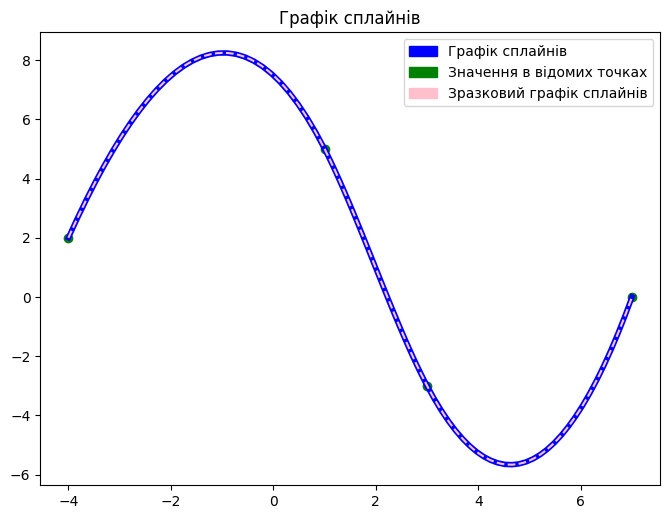

In [39]:
init_fig()
xmin, xmax = X.min(), X.max()
points = plt.plot(X, Y, 'go')
for i in range(len(X)-1):
    lin_space = np.linspace(X[i], X[i+1], 30)
    plt.plot(lin_space, polys[i](lin_space-X[i]), 'b', linewidth=4)
lin_space = np.linspace(xmin, xmax, 100)
lib_S_f = CubicSpline(X, Y, bc_type=((2, Spr_a), (2, Spr_b)))
plt.plot(lin_space, lib_S_f(lin_space), color='pink', linestyle='dashed',)
pink_patch = mpatches.Patch(color='pink', label='Зразковий графік сплайнів')
blue_patch = mpatches.Patch(color='blue', label='Графік сплайнів')
green_patch = mpatches.Patch(color='green', label='Значення в відомих точках')
plt.legend(handles=[blue_patch, green_patch, pink_patch])
plt.title("Графік сплайнів")
plt.show()

### Завдання 3. Розробити програмне забезпечення задачі побудови лінійного та/або кубічного сплайну.
Вже розроблене лишилось тільки оформити в окрему функцію

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display, Markdown, Math
from matplotlib.pyplot import figure
from numpy.polynomial import polynomial
from scipy.sparse import diags

def init_fig():
    global figure
    figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')

# Початкові точки ікс
X = np.array(
    [-4, 1, 3, 7]
)
# Відповідні їм значення функції
Y = np.array(
    [2, 5, -3, 0]
)
# Значення похідних на кінцях
Spr_a = -1
Spr_b = 2

def spline(X, Y, Spr_a, Spr_b):
    H = X[1:] - X[:-1]
    #################################################      DISPLAY
    display(Markdown("#### Таблиця вхідних точок"))
    table = pd.concat([
            pd.DataFrame(X),
            pd.DataFrame(Y),
            pd.DataFrame(np.concatenate([[0], H])),
        ], axis=1)
    table.columns = [
        '$x_i$',
        '$y_i$',
        '$h_i$',
        ]
    display(table.T)
    ###############################################################
    # diagonal-based input
    C_coef_unsolved = diags(
        [
            np.concatenate((H[:-2], np.array([2/3*H[-2]]) )),
            np.concatenate((np.array([2]), (H[1:-1]+H[0:-2])*2, np.array([H[-1]+4/3*H[-2]]) )), 
            np.concatenate((np.array([1]), H[1:-1]))
        ],
        [-1, 0, 1],
        shape=[len(H)]*2
    ).toarray()
    # equals b
    b = np.concatenate((
        np.array([ 3*(Y[1]-Y[0])/H[0]**2 - 3/H[0]*Spr_a ]),
        3*((Y[2:-1]-Y[1:-2])/H[1:-1] - (Y[1:-2]-Y[0:-3])/H[0:-2]),
        np.array([ -Spr_b - 2*((Y[-2] - Y[-3])/H[-2]) + 3*( (Y[-1] - Y[-2])/H[-1] ) ])
    ))
    # solve the system of linear equations
    C = np.linalg.solve(C_coef_unsolved, b)
    A = Y[:-1]

    B_i = (Y[1:-1] - Y[0:-2])/H[:-1] - H[:-1]/3*(C[1:] + 2*C[:-1])
    B_N = np.array([(Y[-2] - Y[-3])/H[-2] + H[-2]/3*(2*C[-1] + C[-2])])
    B = np.concatenate([B_i, B_N])

    D_i = (C[1:] - C[:-1])/(3*H[:-1])
    D_N = np.array([( Spr_b - B[-1] - 2*C[-1]*H[-1] )/(3*H[-1]**2)])
    D = np.concatenate(( D_i, D_N ))

    S = np.concatenate((
            A[:, np.newaxis],
            B[:, np.newaxis],
            C[:, np.newaxis],
            D[:, np.newaxis],
        ),
        axis=1
    )
    polys = [polynomial.Polynomial(i) for i in S]
    #################################################      DISPLAY
    for i in range(len(X)-1):
        polys_disp = [polynomial.Polynomial(i) for i in np.round(S, 3)]
        display(Markdown(f"$x \in \\left[{X[i]};{X[i+1]}\\right]$"))
        display(Markdown(
            polys_disp[i]._repr_latex_(
            ).replace(',x', f',(x - {str(X[i])})' if X[i]>0 else f',(x + {str(X[i])[1:]})')
        ))

    init_fig()
    xmin, xmax = X.min(), X.max()
    points = plt.plot(X, Y, 'go')
    for i in range(len(X)-1):
        lin_space = np.linspace(X[i], X[i+1], 30)
        plt.plot(lin_space, polys[i](lin_space-X[i]), 'b')
    lin_space = np.linspace(xmin, xmax, 100)
    blue_patch = mpatches.Patch(color='blue', label='Графік сплайнів')
    green_patch = mpatches.Patch(color='green', label='Значення в відомих точках')
    plt.legend(handles=[blue_patch, green_patch])
    plt.title("Графік сплайнів")
    plt.show()
    ###############################################################

### Для прикладу візьмемо точки з попередньої лабораторної роботи $\sqrt{5x^3-4x+2}$

#### Таблиця вхідних точок

,0,1,2,3,4,5
$x_i$,-1.0,-0.4000,0.2000,0.8000,1.4000,2.000
$y_i$,1.0,1.8111,1.1136,1.1662,3.1812,5.831
$h_i$,0.0,0.6000,0.6000,0.6000,0.6000,0.600


$x \in \left[-1.0;-0.4\right]$

$x \mapsto \text{1.0} + \text{5.5}\,(x + 1.0) - \text{9.94}\,(x + 1.0)^{2} + \text{5.043}\,(x + 1.0)^{3}$

$x \in \left[-0.4;0.2\right]$

$x \mapsto \text{1.811} - \text{0.981}\,(x + 0.4) - \text{0.862}\,(x + 0.4)^{2} + \text{0.932}\,(x + 0.4)^{3}$

$x \in \left[0.2;0.8\right]$

$x \mapsto \text{1.114} - \text{1.009}\,(x - 0.2) + \text{0.816}\,(x - 0.2)^{2} + \text{1.686}\,(x - 0.2)^{3}$

$x \in \left[0.8;1.4\right]$

$x \mapsto \text{1.166} + \text{1.791}\,(x - 0.8) + \text{3.85}\,(x - 0.8)^{2} - \text{2.064}\,(x - 0.8)^{3}$

$x \in \left[1.4;2.0\right]$

$x \mapsto \text{3.181} + \text{4.183}\,(x - 1.4) + \text{0.136}\,(x - 1.4)^{2} + \text{0.422}\,(x - 1.4)^{3}$

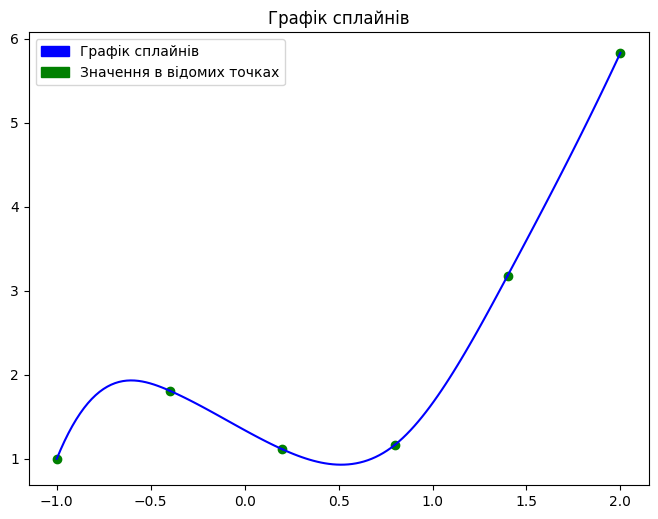

In [6]:
display(Markdown("### Для прикладу візьмемо точки з попередньої лабораторної роботи $\sqrt{5x^3-4x+2}$"))
f = lambda x: np.sqrt(5*x**3-4*x+2)
start = -1
stop = 2.5
step = 0.6
x_i = np.round(np.arange(start, stop, step), 4)
y_i = np.round(f(x_i), 4)
from scipy.misc import derivative
s_a = derivative(f, x_i.min(), n=1, dx=0.0005, order=3)
s_b = derivative(f, x_i.max(), n=1, dx=0.0005, order=3)
spline(
    x_i,
    y_i,
    s_a,
    s_b
)
print("\n"*25)